We have a problem with the following format

$\begin{eqnarray*}
    &\max_{ \{ c_t \}^\infty_{t=0} }& \sum_{t=0}^\infty \beta^t \ln(c_t) + z ln(l_t) \\
    &s.t.& k_{t+1} = (1-\delta)k_{t} + i_t \forall t \\
    & & c_t + i_t = A k_t^\alpha n_t^{1-\alpha} \\
    & & n_t + l_t = 1
\end{eqnarray*}$

Which means that if we take the capital stock as our state variable, future capital and hours worked as our choice variables, and we assume $n_t = 1 \forall t$, our value function can be expressed as a recursive problem:

$\begin{eqnarray*}
    V(k_t) &=& \max_{ \{ k_{t+1} \}^\infty_{t=0} } \ln(A k_t^\alpha + (1-\delta)k_t - k_{t+1}) + \beta V(k_{t+1})
\end{eqnarray*}$

In [1]:
# Imports numpy for calculations
import numpy as np

# Declare the gm class (for growth model)
class gm:

    '''
    Growth model class
    
    Parameters:
     δ = depreciation rate
     α = Cobb-Douglas capital share
     β = discount rate
     a= total factor productivity, exogenous
     steps = steps for discretizing the continuous problem
     M = large number to denote (infinite) negative utility when consumption -> 0
     gridmin = minimum value of capital (small positive value)
     gridmax = minimum value of capital (multiplier for steady state)
     max_iter = number of maximum iterations in the model
     tol = error tolerance to stop the iterations 
     
     Functions:
        u(c): defines and returns the equation for utility
        f(k, n=1): defines and returns the production function,
                   depends on capital (k) and hours worked (n)
        c(k, kp): defines and returns the consumption function
                   depends on capital (k) and future capital (kp)
        k_ss(): defines and returns the steady state capital
                (calculated analytically)
        grid(): returns a linear space of discrete values of given steps
                between the minimum and maximum values for capital
        cvals(): uses grid() to return all possible values of consumption
        uvals(): uses cvals() to return all possible values of utility
        bellman(): iterates the value function to return the maximum possible
        policy and value functions; returns a list of arrays with all the iterations
        
    ''' 
    
    def __init__(self, δ = 0.10, α = 0.3, β = 0.96, a=1, steps=1000, M=10e10,
                 gridmin = 1e-5, gridmax=2, max_iter = 10000, tol=10e-10):
        self.δ, self.α, self.β, self.a, self.steps, self.M = δ, α, β, a, steps, M
        self.gridmin, self.gridmax, self.max_iter, self.tol = gridmin, gridmax, max_iter, tol
        
    def u(c):
        return np.log(c)
    
    def f(self, k, n=1):
        f = self.a * (k**self.α) * (n**(1-self.α))
        return f
    
    def c(self, k, kp):
        c = self.f(k) + (1-self.δ)*k - kp
        return(c)
    
    def k_ss(self):
        return ((1-self.β*(1-self.δ))/(self.α * self.β * self.a))**(1/(self.α-1))
        
    def grid(self):
        start = self.gridmin
        stop = self.k_ss() * self.gridmax
        return np.linspace(start, stop, self.steps)
    
    def cvals(self):
        grid = self.grid(); steps = self.steps; α = self.α; δ = self.δ; a = self.a
        today = np.outer(a*grid**α + (1 - δ)*grid,np.ones(steps))
        tomorrow = np.outer(np.ones(steps), grid)
        return today - tomorrow

    def uvals(self):
        cvals = self.cvals()
        uvals = - self.M * np.ones([self.steps,self.steps])
        uvals[cvals>0] = np.log( (cvals[cvals>0]) )
        return uvals
    
    def bellman(self, max_iter = 0, tol = 0):   
        steps = self.steps; uvals = self.uvals(); β = self.β
        grid = self.grid()
        
        if max_iter == 0:
            max_iter = self.max_iter
        
        if tol == 0:
            tol = self.tol        

        policy_path = []; value_path = []        
        counter = 0; err = self.M
        while (counter < max_iter) and (err > tol):
            if counter == 0:
                v = np.zeros([steps,1]).T

            counter += 1
            v_0 = v

            v_grid = uvals + β * np.outer(np.ones([steps,1]),np.transpose(v))

            v = np.amax(v_grid, axis=1)
            value_path.append(v)
            index = np.argmax(v_grid, axis=1)
            policy_path.append(grid[index])
            
            err = np.max(abs(np.subtract(v_0, v)))
        return policy_path, value_path

In [2]:
# Sets parameters for simulation and initiates class
sim = gm(δ = 0.1, α = 0.3, β = 0.96, a=1)

# Stores policy and value functions
policy, value = sim.bellman()

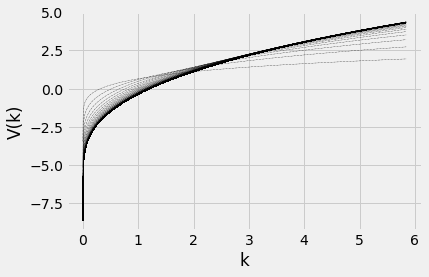

In [3]:
## Plots convergence of value function


import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

fig1 = plt.figure()
plt.xlabel(r'k')
plt.ylabel('V(k)')

grid = sim.grid()

# Prints every value function stored in value
for line in value:
    plt.plot(grid, line, '-.', linewidth=0.3, color='black')
    
plt.tight_layout()
## Plots convergence of value function
plt.show()

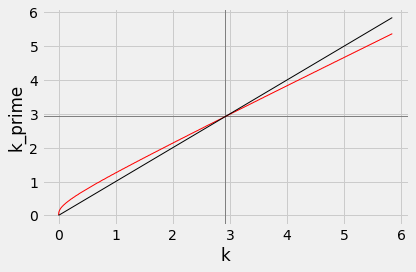

In [4]:
## Plots the final policy function and the 45 degree line (steady state).
## Compares with analytically computed steady state

k_ss = sim.k_ss()
grid = sim.grid()

fig2 = plt.figure()
plt.xlabel(r'k')
plt.ylabel('k_prime')

plt.axvline(k_ss,color='grey', linewidth=1)
plt.axhline(k_ss,color='grey', linewidth=1)
plt.plot(grid, policy[-1], linewidth=1, color='red')
plt.plot(grid, grid, linewidth=1, color='black')    
plt.tight_layout()
plt.show()

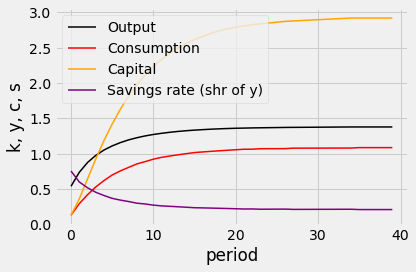

In [5]:
## Plots variable convergence to steady state

# Selects only the optimal policy and value functions
policy, value = policy[-1], value[-1]

# Initiates an arbitrary level of capital
k_t = .01

# Create empty lists to store convergence
k_path, c_path, s_path, y_path = [], [], [], []

# Define horizon
t = 40

# Iterate over time to store dynamics
for period in range(t):
    k = k_t
    k_t = policy[np.argmin(abs(grid-k_t))]
    k_path.append(k_t)
    c_path.append(sim.c(k, k_t))
    y_path.append(sim.f(k_t))
    s_path.append((sim.f(k_t) - sim.c(k, k_t))/sim.f(k_t))

# Plot figure
fig3 = plt.figure()
plt.xlabel(r'period')
plt.ylabel('k, y, c, s')

plt.plot(range(t), y_path, linewidth=1.5, color='black', label='Output')
plt.plot(range(t), c_path, linewidth=1.5, color='red', label='Consumption')
plt.plot(range(t), k_path, linewidth=1.5, color='orange', label='Capital')    
plt.plot(range(t), s_path, linewidth=1.5, color='purple', label='Savings rate (shr of y)')    
plt.legend(loc='upper left')    

plt.tight_layout()
plt.show()